In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import Data

In [3]:
folder = 'C:\\Users\\priye\\OneDrive\\Python_Projects\\Kaggle\\playground-series-s3e5\\'
train_df = pd.read_csv(folder+'train.csv', index_col='Id')

In [4]:
train_df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
Id,,,,,,,,,,,,
617,8.9,0.37,0.45,2.2,0.090,25.0,52.0,0.99702,3.38,0.79,11.4,6
556,8.2,0.48,0.32,3.4,0.079,23.0,113.0,0.99712,3.28,0.66,11.0,8
451,8.0,0.58,0.22,2.1,0.093,38.0,76.0,0.99584,3.30,0.55,10.9,6
1333,10.2,0.22,0.24,2.4,0.095,6.0,22.0,0.99940,3.33,0.87,10.4,6
894,8.8,0.36,0.43,3.0,0.071,18.0,86.0,0.99560,3.30,0.79,12.0,7


# EDA

## Describe

In [13]:
train_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000,2056.000000
mean,8.365175,0.527601,0.265058,2.398881,0.081856,16.955982,49.236868,0.996748,3.310569,0.641308,10.414972,5.720817
std,1.705390,0.173164,0.188267,0.858824,0.023729,10.009710,32.961141,0.001827,0.142321,0.137942,1.028825,0.853146
min,5.000000,0.180000,0.000000,1.200000,0.012000,1.000000,7.000000,0.990070,2.740000,0.390000,8.700000,3.000000
25%,7.200000,0.390000,0.090000,1.900000,0.071000,8.000000,22.000000,0.995600,3.200000,0.550000,9.500000,5.000000
50%,7.950000,0.520000,0.250000,2.200000,0.079000,16.000000,44.000000,0.996700,3.310000,0.610000,10.100000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,24.000000,65.000000,0.997800,3.390000,0.720000,11.000000,6.000000
max,15.900000,1.580000,0.760000,14.000000,0.414000,68.000000,289.000000,1.003690,3.780000,1.950000,14.000000,8.000000


## Boxplots

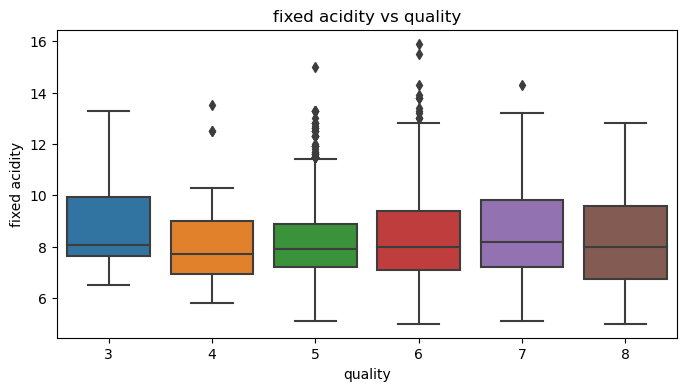

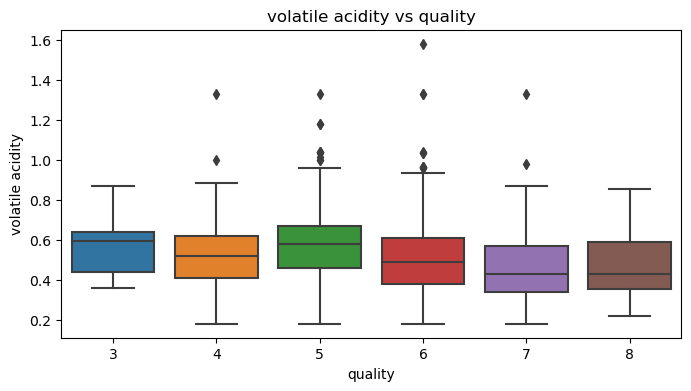

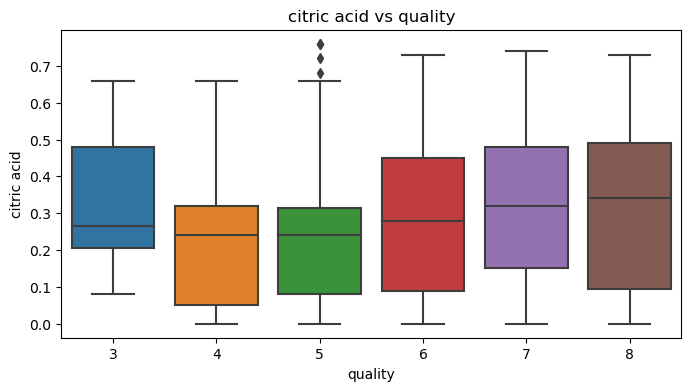

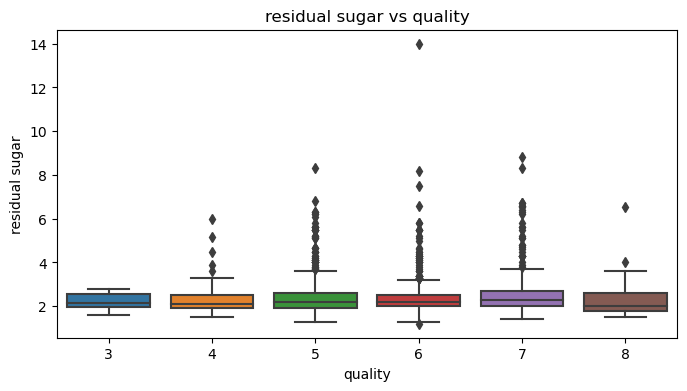

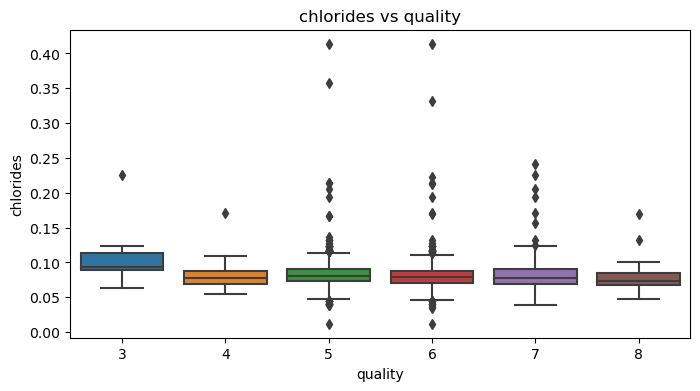

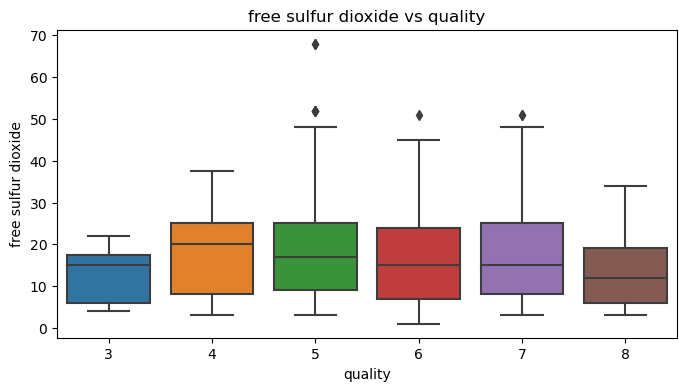

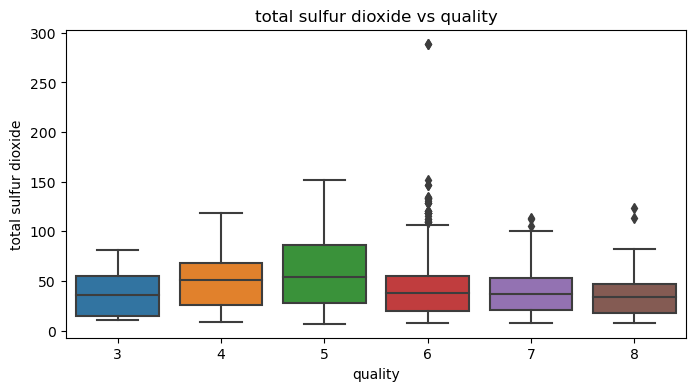

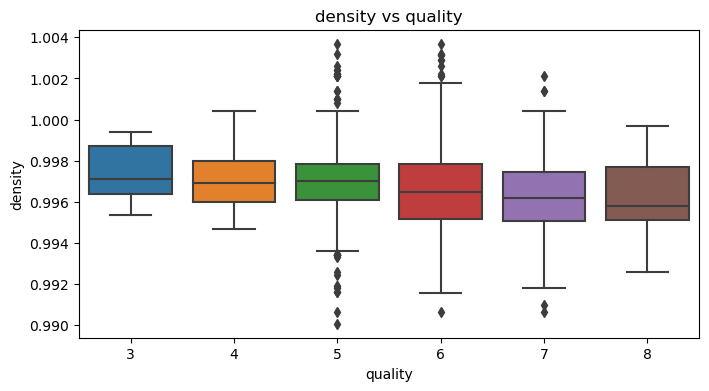

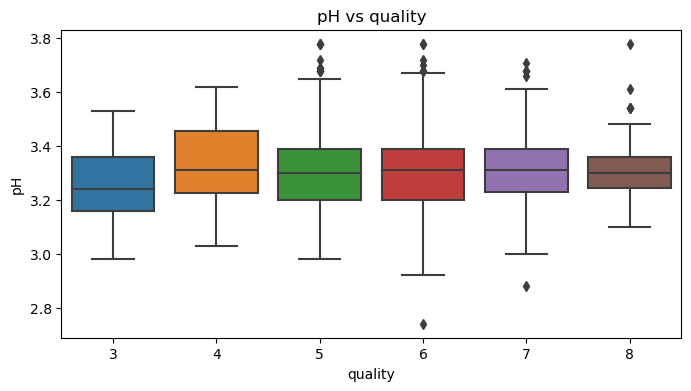

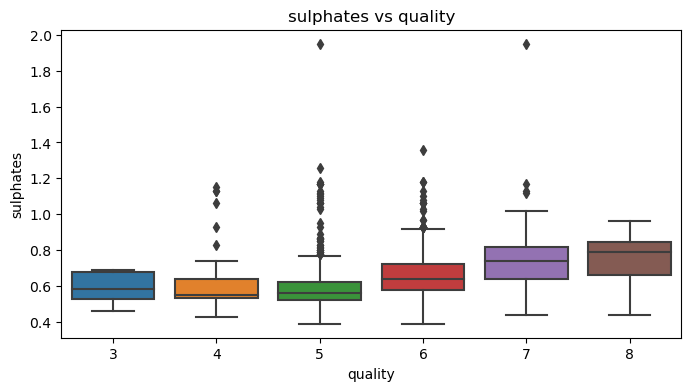

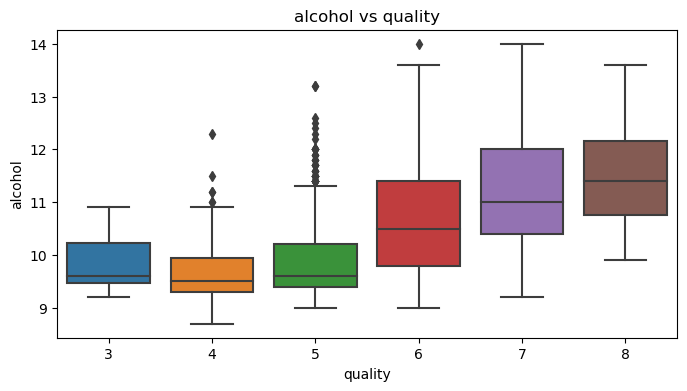

In [12]:
columns = features_df.columns
for c in columns:
    plt.figure(figsize=(8, 4))
    fig = sns.boxplot(data=train_df, x='quality', y=c)
    plt.title(f'{c} vs quality')
    plt.show()

## Correlation

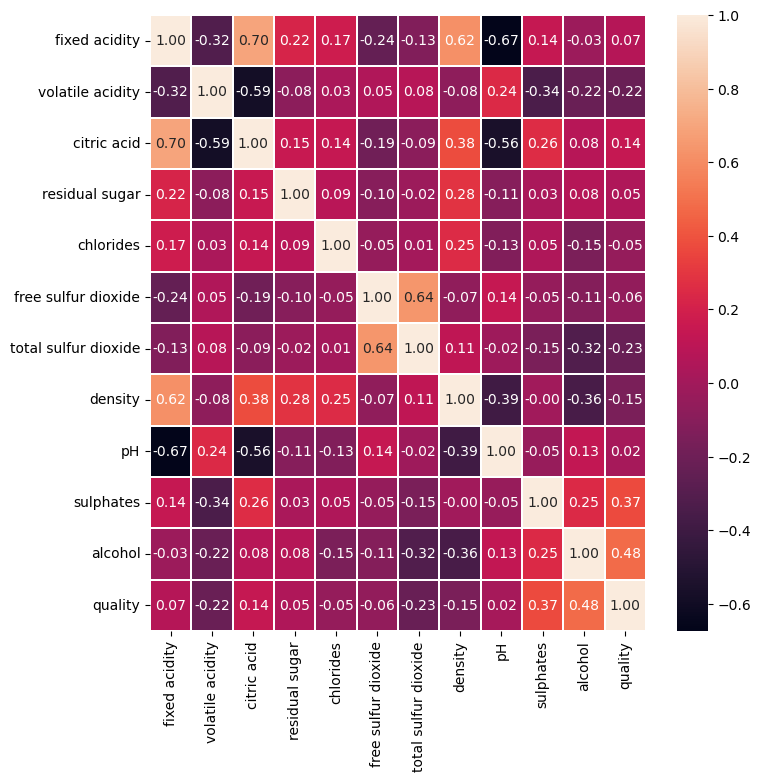

In [14]:
plt.figure(figsize=(8, 8))
fig = sns.heatmap(data=train_df.corr(), annot=True, linewidths=0.05, fmt='.2f')
plt.show()

# Model Fitting

In [38]:
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(
    train_df.drop('quality', axis=1),
    train_df['quality'],
    test_size = 0.2
)

In [71]:
n_classes = len(y_train_df.unique())

In [68]:
X_train = torch.from_numpy(X_train_df.values).float()
y_train_tmp = torch.from_numpy(y_train_df.values).long()
X_val = torch.from_numpy(X_val_df.values).float()
y_val_tmp = torch.from_numpy(y_val_df.values).long()

AttributeError: 'Tensor' object has no attribute 'text'

In [72]:
y_train = torch.nn.functional.one_hot(y_train_tmp, num_classes=n_classes)
y_val = torch.nn.functional.one_hot(y_val_tmp, num_classes=n_classes)

RuntimeError: Class values must be smaller than num_classes.

In [67]:
print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_val.shape = ', X_val.shape)
print('y_val.shape = ', y_val.shape)

X_train.shape =  torch.Size([1644, 11])
y_train.shape =  torch.Size([1644, 9])
X_val.shape =  torch.Size([412, 11])
y_val.shape =  torch.Size([412, 9])


In [58]:
input_size = X_train.shape[1]
output_size = len(y_train.unique())

In [59]:
class Net(nn.Module):
    def __init__(self, hidden_size, activation_fn='relu', apply_dropout=True):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.hidden_size = hidden_size
        self.activation_fn = activation_fn

        self.dropout = None
        if apply_dropout:
            self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        activation_fn = None
        if self.activation_fn == 'sigmoid':
            activation_fn = F.torch.sigmoid
        elif self.activation_fn == 'relu':
            activation_fn = F.torch.relu
        if self.activation_fn == 'tanh':
            activation_fn = F.torch.tanh
        
        x = activation_fn(self.fc1(x))
        if self.dropout != None:
            x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=-1)

In [60]:
def train_and_evaluate_model(model, lr=0.001):
    epoch_data = []
    epochs = 1001

    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_fn = nn.NLLLoss()

    test_accuracy = 0.0

    for epoch in range(1, epochs):
        optimizer.zero_grad()
        model.train()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        y_pred_val = model(X_val)
        loss_test = loss_fn(y_pred_val, y_val)
        _, pred = y_pred_val.data.max(1)
        test_accuracy = pred.eq(y_val.data).sum().item() / y_val.values.size
        epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), test_accuracy])
        if epoch % 100 == 0:
            print(f'epoch = {epoch} | train loss = {loss.data.item():.2f} | test loss = {loss_test.data.item():.2f} | test acc = {test_accuracy:.2f}')
        
    return {
        'model': model,
        'epoch_data': epoch_data,
        'num_epochs': epochs,
        'optimizer': optimizer,
        'loss_fn': loss_fn,
        'test_accuracy': test_accuracy,
        'pred': y_pred_val.data.max(1),
        'y_val': y_val
    }

In [61]:
net = Net(hidden_size=8, activation_fn='sigmoid', apply_dropout=False)
net

Net(
  (fc1): Linear(in_features=11, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=6, bias=True)
)

In [62]:
result_8_sigmoid = train_and_evaluate_model(net)

IndexError: Target 6 is out of bounds.